<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/FInal/S10-Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

**<h2>Install Albumentations and Apex librabies</h2>**

In [2]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-w91lascc
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-w91lascc
     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=80fc3271379ad4ca5598107b6143a415c9b82e38bbe7b9f596a3db89e33f011a
  Stored in directory: /tmp/pip-ephem-wheel-cache-e6p3teug/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=98c05bd8df4696a6b8199aea77e8ee1b8035c01cafc36c986be6e952201f8b24
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



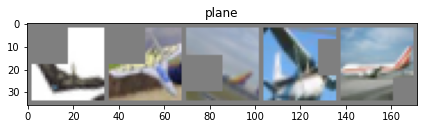

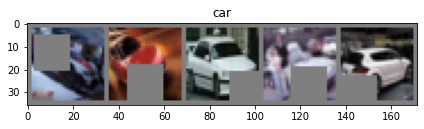

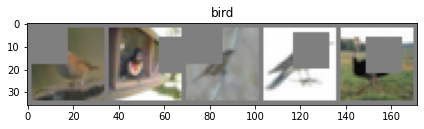

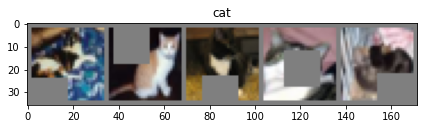

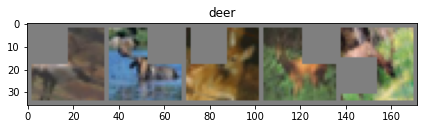

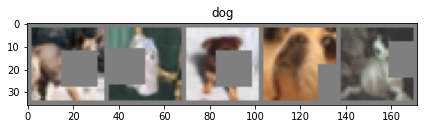

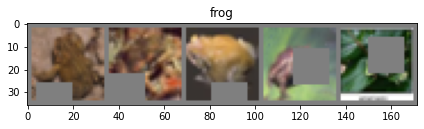

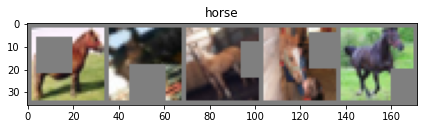

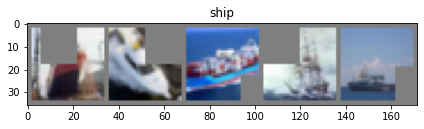

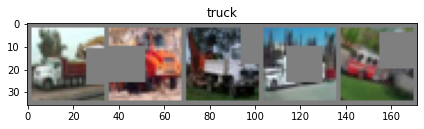

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


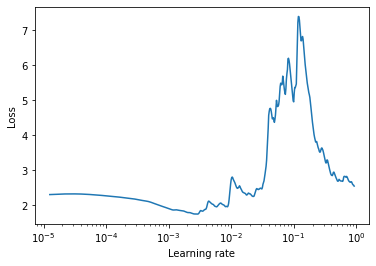

In [10]:
lrfinder.plot()

In [11]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(Best_lr)

0.0028729848333536637


In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

In [14]:
train_loss=[]
train_acc=[]
EPOCHS = 50

for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      train_loss, train_acc = train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
      test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
      scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0028729848333536637


Loss=1.30757737159729 Batch_id=390 Accuracy=42.09: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5730/10000 (57.30%)

EPOCH: 2 LR: 0.0028729848333536637


Loss=1.0380644798278809 Batch_id=390 Accuracy=56.25: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6142/10000 (61.42%)

EPOCH: 3 LR: 0.0028729848333536637


Loss=0.9635658264160156 Batch_id=390 Accuracy=62.75: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 6838/10000 (68.38%)

EPOCH: 4 LR: 0.0028729848333536637


Loss=0.8801330327987671 Batch_id=390 Accuracy=66.93: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7417/10000 (74.17%)

EPOCH: 5 LR: 0.0028729848333536637


Loss=0.8014885783195496 Batch_id=390 Accuracy=69.95: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7635/10000 (76.35%)

EPOCH: 6 LR: 0.0028729848333536637


Loss=0.6986931562423706 Batch_id=390 Accuracy=72.29: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7682/10000 (76.82%)

EPOCH: 7 LR: 0.0028729848333536637


Loss=0.984488308429718 Batch_id=390 Accuracy=74.09: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7964/10000 (79.64%)

EPOCH: 8 LR: 0.0028729848333536637


Loss=0.8311106562614441 Batch_id=390 Accuracy=75.58: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7934/10000 (79.34%)

EPOCH: 9 LR: 0.0028729848333536637


Loss=0.8401579856872559 Batch_id=390 Accuracy=76.97: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8158/10000 (81.58%)

EPOCH: 10 LR: 0.0028729848333536637


Loss=0.6082622408866882 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8284/10000 (82.84%)

EPOCH: 11 LR: 0.0028729848333536637


Loss=0.6043749451637268 Batch_id=390 Accuracy=79.07: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8409/10000 (84.09%)

EPOCH: 12 LR: 0.0028729848333536637


Loss=0.5935260653495789 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8427/10000 (84.27%)

EPOCH: 13 LR: 0.0028729848333536637


Loss=0.7103630304336548 Batch_id=390 Accuracy=80.67: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8506/10000 (85.06%)

EPOCH: 14 LR: 0.0028729848333536637


Loss=0.4272352159023285 Batch_id=390 Accuracy=81.66: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8398/10000 (83.98%)

EPOCH: 15 LR: 0.0028729848333536637


Loss=0.6961830258369446 Batch_id=390 Accuracy=82.00: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8448/10000 (84.48%)

EPOCH: 16 LR: 0.0028729848333536637


Loss=0.31706732511520386 Batch_id=390 Accuracy=82.62: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8387/10000 (83.87%)

EPOCH: 17 LR: 0.00028729848333536637


Loss=0.42062896490097046 Batch_id=390 Accuracy=85.98: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8858/10000 (88.58%)

EPOCH: 18 LR: 0.00028729848333536637


Loss=0.5386002659797668 Batch_id=390 Accuracy=86.67: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8879/10000 (88.79%)

EPOCH: 19 LR: 0.00028729848333536637


Loss=0.2833026051521301 Batch_id=390 Accuracy=87.06: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8870/10000 (88.70%)

EPOCH: 20 LR: 0.00028729848333536637


Loss=0.4905274510383606 Batch_id=390 Accuracy=87.14: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8888/10000 (88.88%)

EPOCH: 21 LR: 0.00028729848333536637


Loss=0.27977097034454346 Batch_id=390 Accuracy=87.47: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8899/10000 (88.99%)

EPOCH: 22 LR: 0.00028729848333536637


Loss=0.46437177062034607 Batch_id=390 Accuracy=87.73: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8913/10000 (89.13%)

EPOCH: 23 LR: 0.00028729848333536637


Loss=0.19118839502334595 Batch_id=390 Accuracy=87.93: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8923/10000 (89.23%)

EPOCH: 24 LR: 0.00028729848333536637


Loss=0.306441992521286 Batch_id=390 Accuracy=88.19: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8917/10000 (89.17%)

EPOCH: 25 LR: 0.00028729848333536637


Loss=0.2604822516441345 Batch_id=390 Accuracy=88.18: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8917/10000 (89.17%)

EPOCH: 26 LR: 0.00028729848333536637


Loss=0.2960495948791504 Batch_id=390 Accuracy=88.23: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8930/10000 (89.30%)

EPOCH: 27 LR: 0.00028729848333536637


Loss=0.4116930067539215 Batch_id=390 Accuracy=88.63: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8934/10000 (89.34%)

EPOCH: 28 LR: 0.00028729848333536637


Loss=0.3735010623931885 Batch_id=390 Accuracy=88.76: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8959/10000 (89.59%)

EPOCH: 29 LR: 0.00028729848333536637


Loss=0.3117375373840332 Batch_id=390 Accuracy=88.78: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8945/10000 (89.45%)

EPOCH: 30 LR: 0.00028729848333536637


Loss=0.33208364248275757 Batch_id=390 Accuracy=88.89: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8936/10000 (89.36%)

EPOCH: 31 LR: 0.00028729848333536637


Loss=0.36122676730155945 Batch_id=390 Accuracy=89.17: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8945/10000 (89.45%)

EPOCH: 32 LR: 0.00028729848333536637


Loss=0.3146952986717224 Batch_id=390 Accuracy=89.33: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8953/10000 (89.53%)

EPOCH: 33 LR: 0.0001


Loss=0.27175337076187134 Batch_id=390 Accuracy=89.47: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8962/10000 (89.62%)

EPOCH: 34 LR: 0.0001


Loss=0.42738810181617737 Batch_id=390 Accuracy=89.65: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8971/10000 (89.71%)

EPOCH: 35 LR: 0.0001


Loss=0.31712037324905396 Batch_id=390 Accuracy=89.70: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8967/10000 (89.67%)

EPOCH: 36 LR: 0.0001


Loss=0.3005502223968506 Batch_id=390 Accuracy=89.73: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8965/10000 (89.65%)

EPOCH: 37 LR: 0.0001


Loss=0.34021735191345215 Batch_id=390 Accuracy=89.77: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8966/10000 (89.66%)

EPOCH: 38 LR: 0.0001


Loss=0.34203988313674927 Batch_id=390 Accuracy=89.64: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8985/10000 (89.85%)

EPOCH: 39 LR: 0.0001


Loss=0.30999377369880676 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8970/10000 (89.70%)

EPOCH: 40 LR: 0.0001


Loss=0.31976622343063354 Batch_id=390 Accuracy=89.93: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8972/10000 (89.72%)

EPOCH: 41 LR: 0.0001


Loss=0.19591601192951202 Batch_id=390 Accuracy=89.96: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8965/10000 (89.65%)

EPOCH: 42 LR: 0.0001


Loss=0.28294622898101807 Batch_id=390 Accuracy=90.02: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8983/10000 (89.83%)

EPOCH: 43 LR: 0.0001


Loss=0.32843559980392456 Batch_id=390 Accuracy=90.09: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8978/10000 (89.78%)

EPOCH: 44 LR: 0.0001


Loss=0.28879088163375854 Batch_id=390 Accuracy=90.22: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8996/10000 (89.96%)

EPOCH: 45 LR: 0.0001


Loss=0.3060440123081207 Batch_id=390 Accuracy=90.14: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8976/10000 (89.76%)

EPOCH: 46 LR: 0.0001


Loss=0.4632546305656433 Batch_id=390 Accuracy=90.29: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

EPOCH: 47 LR: 0.0001


Loss=0.27965018153190613 Batch_id=390 Accuracy=90.30: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8987/10000 (89.87%)

EPOCH: 48 LR: 0.0001


Loss=0.29716020822525024 Batch_id=390 Accuracy=90.29: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8974/10000 (89.74%)

EPOCH: 49 LR: 0.0001


Loss=0.3644312024116516 Batch_id=390 Accuracy=90.28: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8977/10000 (89.77%)

EPOCH: 50 LR: 0.0001


Loss=0.2611672580242157 Batch_id=390 Accuracy=90.35: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]



Test set: Average loss: 0.0024, Accuracy: 8987/10000 (89.87%)



In [15]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 89.870 %


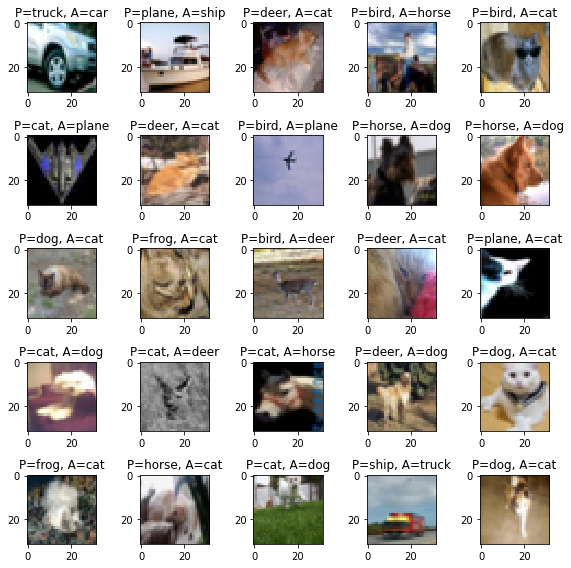

In [16]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [17]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 76 %
Accuracy of  deer : 93 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %


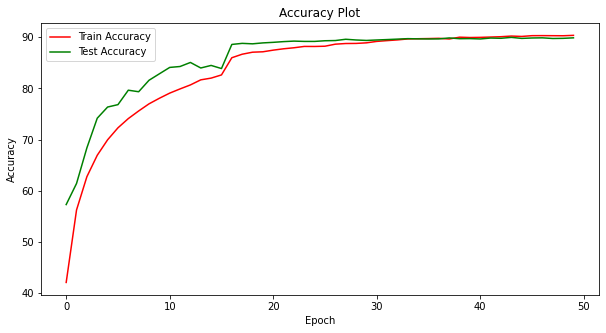

In [18]:
#import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1,2, figsize=(15,10))

# axs[0].plot(train_acc)
# axs[0].plot(test_acc)
# axs[0].set_title("Accuracy Change")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_test.train_acc_epoch_end,color = 'r',label="Train Accuracy")
ax.plot(train_test.test_acc,color = 'g',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

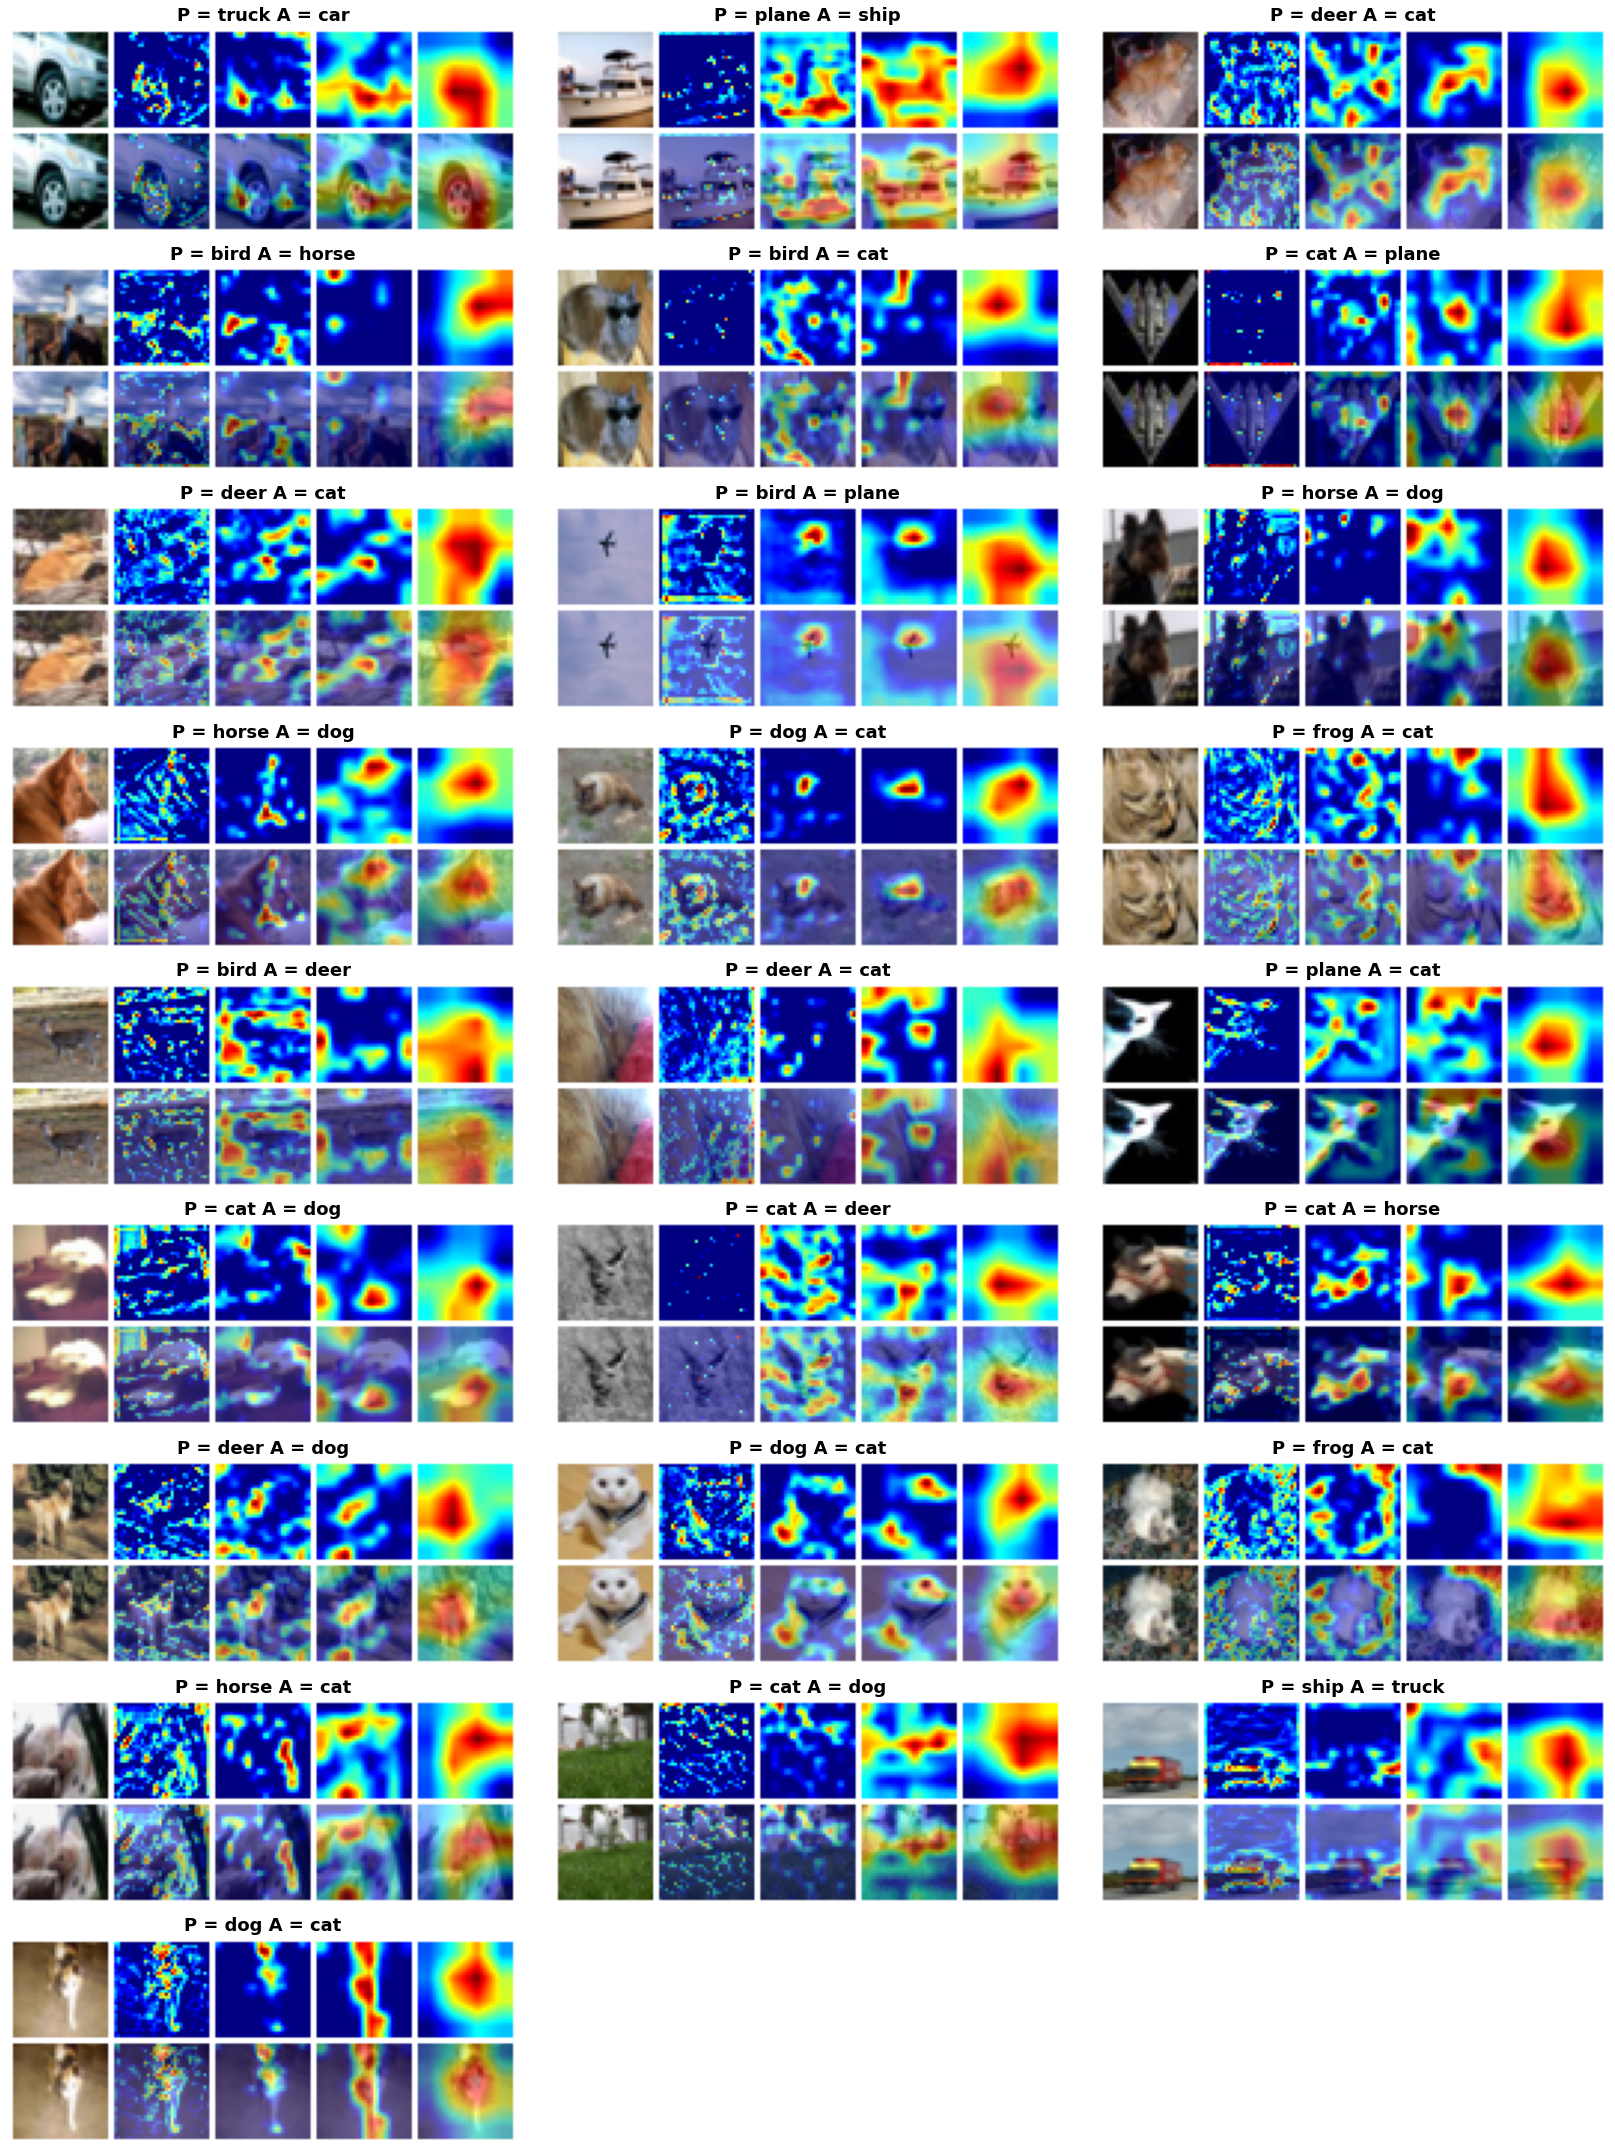

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)